# Car Prices

### Introduction
This notebook demonstrates a structured preprocessing workflow applied to a car price dataset.
The main goal is to prepare the data for machine-learning modeling by ensuring its quality, consistency, and interpretability.

The steps include:
- Detecting and removing duplicates
- Handling missing data
- Identifying and filtering outliers
- Scaling numerical features
- Encoding categorical variables
- Performing feature selection

Each step is explained with concise technical reasoning and clean, reproducible code.

### 0 - Import Libraries, Packages, and Load the Dataset

In [74]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels and SciKit-Learn libraries
from statsmodels.graphics.gofplots import qqplot
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [75]:
df = pd.read_csv("data/raw_cars_dataset.csv")
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,64.1,2548,dohc,four,2.68,5000,expensive
1,std,front,64.1,2548,dohc,four,2.68,5000,expensive
2,std,front,65.5,2823,ohcv,six,3.47,5000,expensive
3,std,front,NaN,2337,ohc,four,3.40,5500,expensive
4,std,front,66.4,2824,ohc,five,3.40,5500,expensive


---

### 1 - Duplicate Removal

Before starting any analysis, it’s essential to ensure that all records in the dataset are unique.\
Duplicate rows can bias statistical measures and inflate model accuracy if the same data appears in both training and test sets.

In [76]:
# Check number of duplicates
df.duplicated().sum()

14

We have a total of 14 duplicates. I am now going to remove then, in order to have a cleaner dataset.

In [77]:
# Remove duplicates + Check before/after
print(f"Rows before: {len(df)}")
df = df.drop_duplicates()
print(f"Rows after: {len(df)}")

Rows before: 205
Rows after: 191


---

## 2 - Handling Missing Data

Missing data can lead to biased analysis or even prevent certain algorithms from running.
In this step, I identify the columns with missing values, analyze their proportion, and decide whether to impute or drop them depending on their significance.\
As general rule of thumb, columns with many missing values (over 30–50%) are dropped, while smaller gaps are filled using imputation techniques such as mean, median, or mode.

In [78]:
# Display missing value ratio (runded by 2 decimals)
round(df.isnull().sum().sort_values(ascending=False)/len(df), 2)

enginelocation    0.05
carwidth          0.01
aspiration        0.00
curbweight        0.00
enginetype        0.00
cylindernumber    0.00
stroke            0.00
peakrpm           0.00
price             0.00
dtype: float64

Luckily, most of the features have no missing value, aside of *enginelocation* and *carwidth*. Therefore, my next step will be going through them and see how to handle their missing values.

### `carwidth`

I will start with <code>carwidth</code>.

In [79]:
# Check unique values for the 'carwidth' column
df.carwidth.value_counts(dropna=False)

carwidth
66.5    22
63.8    19
65.4    15
63.6     9
68.4     9
64       9
64.4     9
65.5     8
65.2     7
65.6     6
64.2     6
66.3     6
67.2     6
66.9     5
67.9     5
*        4
68.9     4
71.7     3
70.3     3
65.7     3
63.9     3
64.8     3
65       2
67.7     2
68.3     2
71.4     2
NaN      2
66.6     1
63.4     1
72.3     1
64.1     1
68       1
72       1
70.5     1
66.1     1
70.6     1
69.6     1
61.8     1
66       1
64.6     1
60.3     1
70.9     1
66.4     1
68.8     1
Name: count, dtype: int64

Some values are indicated as *, something that our model could obviously not interpret. To ensure a consistent treatment, I will convert them to NaN, and then calculate the median value using Simple Imputer.

**Why so?**\
Luckily, we are dealing with a small percentage of numerical data (less than 30%, following our rule of thumb), therefore we do not have to drop the whole feature data.

In [80]:
# Replace '*' for NaN, to ensure consistency
df = df.replace("*", np.nan)

# Instantiate the SimpleImputer, using the median
carwidth_imp = SimpleImputer(strategy='median')

# Fit and transform the imputer to the feature
df['carwidth'] = carwidth_imp.fit_transform(df[['carwidth']])

I will quickly check that there are no more * values left in the dataset.

In [81]:
# Checking how many times "*" appears. None = 0
df.value_counts().get('*', 0)

0

### `enginelocation`

<details>
    <summary>💡 <i>Hint</i> </summary>
    <br>
    ℹ️ Considering that <code>enginelocation</code> is a categorical feature, and that the vast majority of the category is <code>front</code>, impute with the most frequent.
</details>

Given a first look, <code>enginelocation</code> is probably containing only categorical variables.

In [82]:
# Check unique values and what they are
print(df.enginelocation.nunique())
print(df.enginelocation.value_counts(dropna=False))

2
enginelocation
front    179
NaN       10
rear       2
Name: count, dtype: int64


There 10 NaN values, and the other two variables are indeed categorical (**front** and **rear**).

The vast majority of cars in the dataset has their engine located to the front. The best strategy here is using another Simple Imputer with most frequent value.

In [83]:
# Instantiate new SimpleImputer with most_frequent strategy
eng_loc_imputer = SimpleImputer(strategy='most_frequent')

# Fit imputer to the feature
eng_loc_imputer.fit(df[['enginelocation']])

# Apply imputer
df[['enginelocation']] = eng_loc_imputer.transform(df[['enginelocation']])

In [84]:
# Quick check
print(df.enginelocation.value_counts(dropna=False))

enginelocation
front    189
rear       2
Name: count, dtype: int64


Perfect. All NaN values converted to *front*, the most frequent value.

---

## 3 - Scaling Numerical Features

Features are analyzed for distribution and outliers to determine the correct scaling method:

- **RobustScaler** is applied to features with normal distributions containing outliers (*peakrpm*, *carwidth*, *stroke*).

- **StandardScaler** is applied to features with normally distributed values and no outliers (*curbweight*).

In [85]:
# Displaying which features are numerical (int64, float64)
# And which ones are categorical (object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   aspiration      191 non-null    object 
 1   enginelocation  191 non-null    object 
 2   carwidth        191 non-null    float64
 3   curbweight      191 non-null    int64  
 4   enginetype      191 non-null    object 
 5   cylindernumber  191 non-null    object 
 6   stroke          191 non-null    float64
 7   peakrpm         191 non-null    int64  
 8   price           191 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 14.9+ KB


I will include all the numerical features in a variable, which makes it easier to manage them all at the same time.

In [86]:
# Here are the numerical features of the dataset we need to scale
numerical_features = df.select_dtypes(exclude=['object']).columns
numerical_features

Index(['carwidth', 'curbweight', 'stroke', 'peakrpm'], dtype='object')

In [87]:
df[numerical_features].describe()

,carwidth,curbweight,stroke,peakrpm
count,191.000000,191.000000,191.000000,191.000000
mean,65.961257,2573.204188,3.259607,5113.089005
std,2.096279,525.724187,0.317996,471.879096
min,60.300000,1488.000000,2.070000,4150.000000
25%,64.200000,2190.500000,3.110000,4800.000000
50%,65.500000,2443.000000,3.290000,5100.000000
75%,66.900000,2964.500000,3.410000,5500.000000
max,72.300000,4066.000000,4.170000,6600.000000


### `peakrpm`

<details>
    <summary>💡 <i>Hint</i> </summary>

    
ℹ️ <code>peakrpm</code>, <code>carwidth</code>, & <code>stroke</code> have normal distributions but also some outliers. Hence, it is advisable to use `RobustScaler()`.
</details>

### Checking distribution and outliers before scaling

Before applying any scaling technique, it’s important to analyze how each numerical feature is distributed. The following three plots give complementary insights:

- **Histogram**: shows the overall distribution shape, whether the data follow a normal (bell) curve or are skewed.
- **Boxplot**: highlights spread and outliers, where points far outside the whiskers indicate extreme values that may affect scaling.
- **QQ Plot (Quantile–Quantile Plot)**: compares the feature’s quantiles to those of a perfect normal distribution. If the points follow the diagonal line, the data are approximately normal.

These visuals help determine the most appropriate scaling method:
- **StandardScaler** for normally distributed data without strong outliers.
- **RobustScaler** when the feature is roughly normal but contains visible outliers.

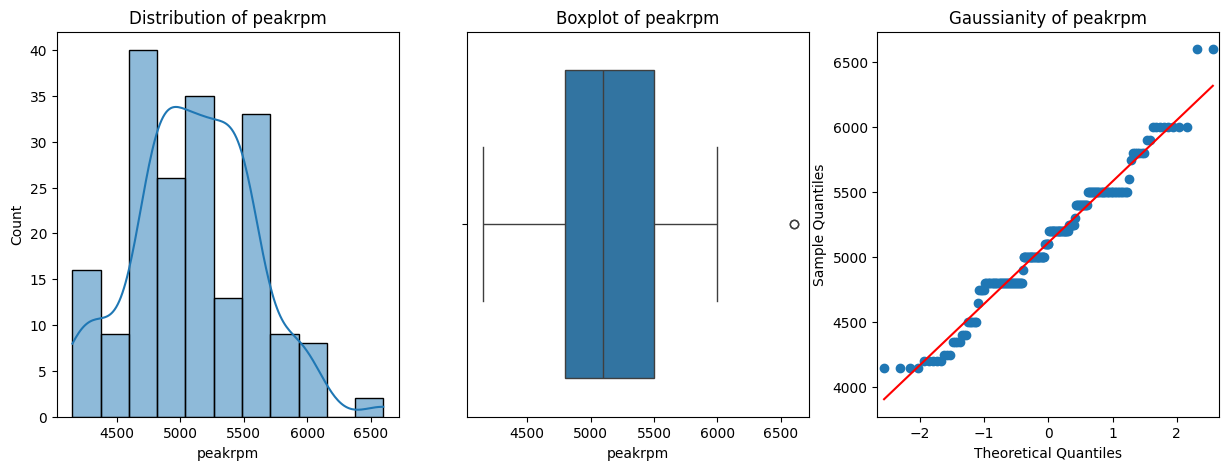

In [88]:
# Define variable
variable = 'peakrpm'

# Define number of subplots (3 here)
fig, ax = plt.subplots(1,3,figsize=(15,5))

# First plot - Histogram
ax[0].set_title(f"Distribution of {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

# Second plot - Boxplot
ax[1].set_title(f"Boxplot of {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])

# Third plot - Gaussianity (QQplot)
ax[2].set_title(f"Gaussianity of {variable}")
qqplot(df[f"{variable}"],line='s',ax=ax[2])

plt.show()

**Conclusions:**
We are witnessing a normal distribution with some outliers, as shown by the boxplot. This feature is suitable for the Robust Scaler.

### `carwidth`

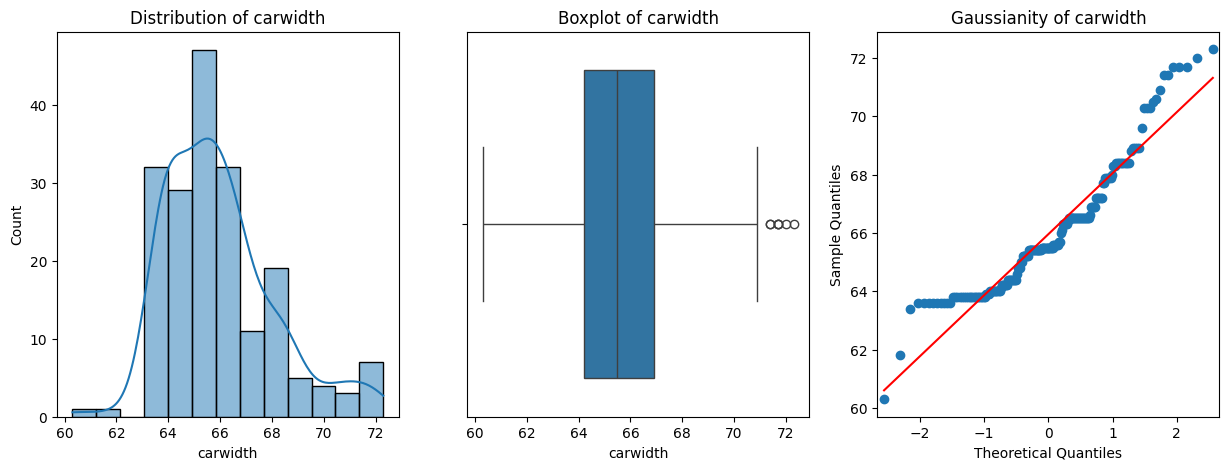

In [89]:
# Define variable
variable = 'carwidth'

# Define number of subplots (3 here)
fig, ax = plt.subplots(1,3,figsize=(15,5))

# First plot - Histogram
ax[0].set_title(f"Distribution of {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

# Second plot - Boxplot
ax[1].set_title(f"Boxplot of {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])

# Third plot - Gaussianity (QQplot)
ax[2].set_title(f"Gaussianity of {variable}")
qqplot(df[f"{variable}"],line='s',ax=ax[2])

plt.show()

**Conclusions:** Again, the distribution is normal and with outliers. This feature will be scaled with the Robust Scaler as well.

### `stroke`

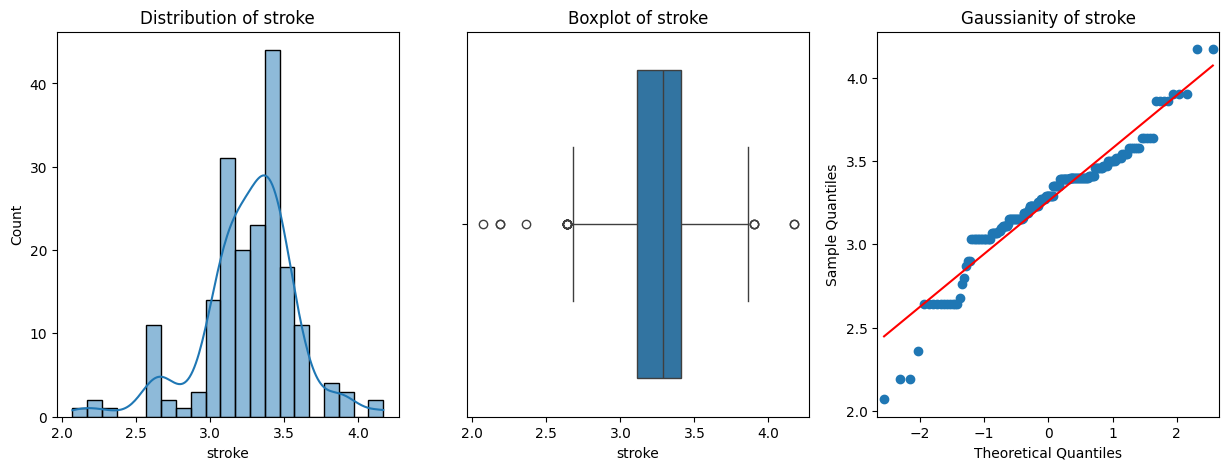

In [90]:
# Define variable
variable = 'stroke'

# Define number of subplots (3 here)
fig, ax = plt.subplots(1,3,figsize=(15,5))

# First plot - Histogram
ax[0].set_title(f"Distribution of {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

# Second plot - Boxplot
ax[1].set_title(f"Boxplot of {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])

# Third plot - Gaussianity (QQplot)
ax[2].set_title(f"Gaussianity of {variable}")
qqplot(df[f"{variable}"],line='s',ax=ax[2])

plt.show()

**Conclusion:** Once again, we have a normal distributions with (even more) outliers. Even with this third feature, Robust Scaler will be our choice

### `curbweight`

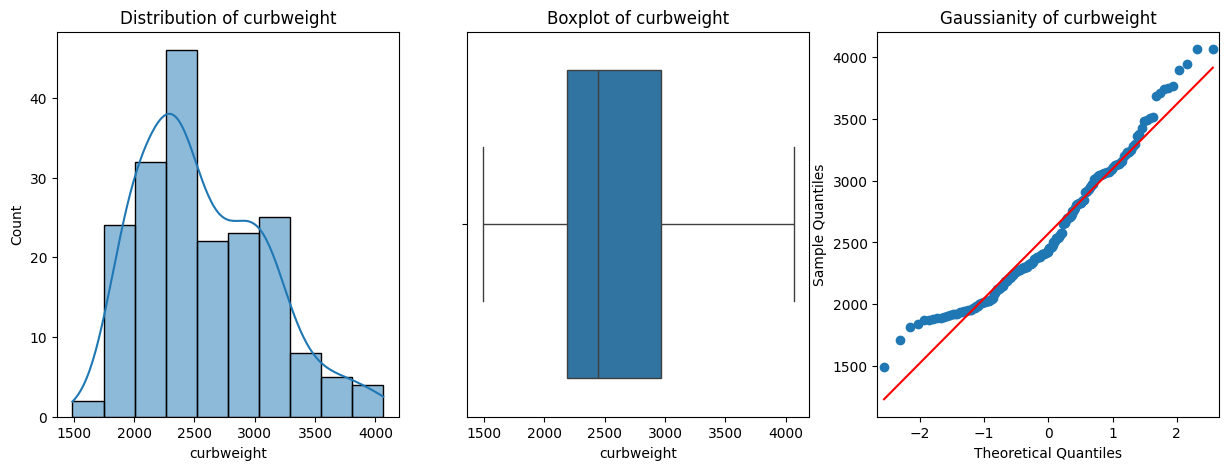

In [91]:
# Define variable
variable = 'curbweight'

# Define number of subplots (3 here)
fig, ax = plt.subplots(1,3,figsize=(15,5))

# First plot - Histogram
ax[0].set_title(f"Distribution of {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

# Second plot - Boxplot
ax[1].set_title(f"Boxplot of {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])

# Third plot - Gaussianity (QQplot)
ax[2].set_title(f"Gaussianity of {variable}")
qqplot(df[f"{variable}"],line='s',ax=ax[2])

plt.show()

**Conclusions:**
This feature shows a Gaussian distribution with no outliers, meaning that will be scaled using a Standard Scaler.

### Scaling Features with Robust Scaler

In [92]:
# Instantiate RobustScaler
rb_scaler = RobustScaler()

# Fit and transform scaler to the features
df['peakrpm'], df['carwidth'], df['stroke'] = rb_scaler.fit_transform(df[['peakrpm','carwidth','stroke']]).T
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,-0.518519,2548,dohc,four,-2.033333,-0.142857,expensive
2,std,front,0.000000,2823,ohcv,six,0.600000,-0.142857,expensive
3,std,front,0.000000,2337,ohc,four,0.366667,0.571429,expensive
4,std,front,0.333333,2824,ohc,five,0.366667,0.571429,expensive
5,std,front,0.296296,2507,ohc,five,0.366667,0.571429,expensive


### Scaling Features with Standard Scaler

In [93]:

# Instantiate Standart Scaler
std_scaler = StandardScaler()

# Fit the scaler to feature
std_scaler.fit(df[['curbweight']])

# Transform
df['curbweight'] = std_scaler.transform(df[['curbweight']])

df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,-0.518519,-0.048068,dohc,four,-2.033333,-0.142857,expensive
2,std,front,0.000000,0.476395,ohcv,six,0.600000,-0.142857,expensive
3,std,front,0.000000,-0.450474,ohc,four,0.366667,0.571429,expensive
4,std,front,0.333333,0.478302,ohc,five,0.366667,0.571429,expensive
5,std,front,0.296296,-0.126260,ohc,five,0.366667,0.571429,expensive


---

## 4 - Encoding the categorical features

Categorical variables are transformed into numerical format so that machine-learning algorithms can interpret them. Encoding methods are selected based on feature type:

- **One-Hot Encoding** for binary and multi-category nominal variables (*aspiration*, *enginelocation*, *enginetype*)

- **Manual Ordinal** Encoding for ordered categories (*cylindernumber*)

- **Label Encoding** for the target variable (*price*)


### `aspiration` & `enginelocation`

These two features are both binary categorical, without any natural order. As mentioned above, we are going to use the One-Hot Encoder.

In [94]:
# Showing the unique variables for each feature
print(f'The unique variables for "aspiration" are {df.aspiration.unique()}')
print(f'The unique variables for "enginelocation" are {df.enginelocation.unique()}')

The unique variables for "aspiration" are ['std' 'turbo']
The unique variables for "enginelocation" are ['front' 'rear']


In [95]:
# Apply OneHotEncoder to binary features
binary_ohe = OneHotEncoder(sparse_output=False, drop='if_binary')

# Fit and transform the selected columns
encoded = binary_ohe.fit_transform(df[['aspiration', 'enginelocation']])

# Create a DataFrame with the new encoded columns
encoded_df = pd.DataFrame(
    encoded,
    columns=binary_ohe.get_feature_names_out(['aspiration', 'enginelocation']),
    index=df.index
)

# Merge encoded columns and drop originals
df = pd.concat([df.drop(columns=['aspiration', 'enginelocation']), encoded_df], axis=1)
df.head()

,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price,aspiration_turbo,enginelocation_rear
0,-0.518519,-0.048068,dohc,four,-2.033333,-0.142857,expensive,0.0,0.0
2,0.000000,0.476395,ohcv,six,0.600000,-0.142857,expensive,0.0,0.0
3,0.000000,-0.450474,ohc,four,0.366667,0.571429,expensive,0.0,0.0
4,0.333333,0.478302,ohc,five,0.366667,0.571429,expensive,0.0,0.0
5,0.296296,-0.126260,ohc,five,0.366667,0.571429,expensive,0.0,0.0


The process above created a single column for each binary feature, replacing text categories with numeric values (0 and 1). As a result, the data is now numerical, allowing it to be processed by machine-learning models. The model can now directly interpret whether a car has, for instance, a turbo engine (1) or not (0).

### `enginetype`

In [96]:
# Check the amount of unique values
df.enginetype.unique()

array(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf', 'dohcv'], dtype=object)

What we see above are multiple categories, not related by any natural order. This means that we are going to use the One-Hot Encoder again.

In [97]:
# Instantiate OHC
eng_ohc = OneHotEncoder(sparse_output=False)

# Fit Encoder to data
eng_ohc.fit(df[['enginetype']])

# Show names of generated columns
display(eng_ohc.get_feature_names_out())

# Encode 'enginetype'
eng_type_encoded = eng_ohc.transform(df[['enginetype']])

# Transform the current feature-related column
df[eng_ohc.get_feature_names_out()] = eng_type_encoded

# Drop the column "enginetype" which has been encoded
df = df.drop(columns=["enginetype"])

# Show the dataset
df.head(3)

array(['enginetype_dohc', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor'], dtype=object)

,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspiration_turbo,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,four,-2.033333,-0.142857,expensive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,six,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,four,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Each category is now converted into its own binary column, making sure that the algorithm treats each engine type independently, without impluing any ordinal relationship.

### `cylindernumber`

In [98]:
# Check unique values
df.cylindernumber.unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

This is an ordinal feature whose values need to be made numerical. To do so, I will use the Ordinal Encoding.

In [99]:
# Define the custom order of categories (from smallest to largest)
categories = [['two', 'three', 'four', 'five', 'six', 'eight', 'twelve']]

# Instantiate the encoder with that order
ord_enc = OrdinalEncoder(categories=categories)

# Fit and transform the feature
df['cylindernumber'] = ord_enc.fit_transform(df[['cylindernumber']])

# Show changes
df.head()

,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspiration_turbo,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,2.0,-2.033333,-0.142857,expensive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,4.0,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,2.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,3.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,3.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now that we have numerical values, we should think whether this it is necessary to scale this feature as well or not. I am going to re-use the same 3 plots (histogram, boxplot, and QQplot).

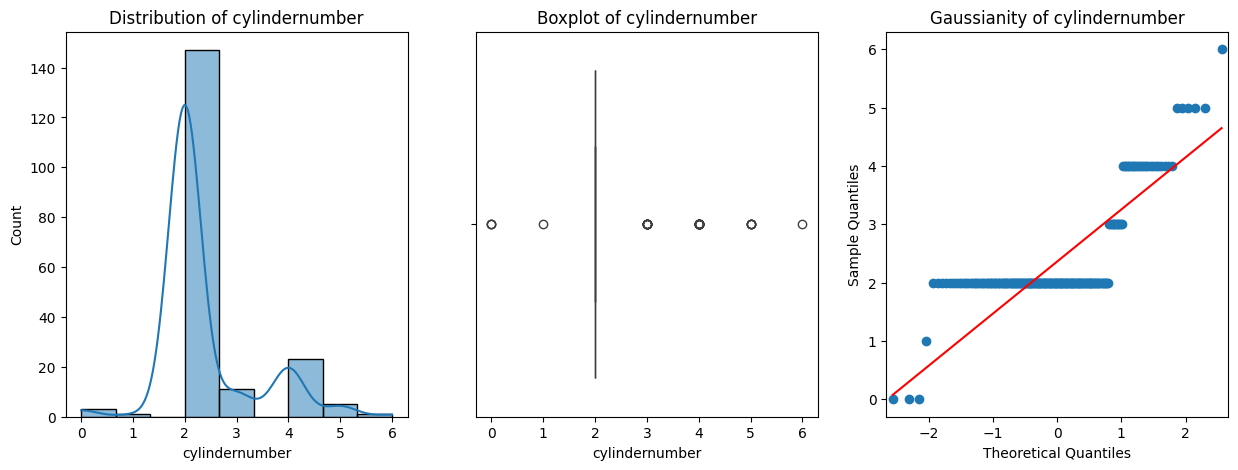

In [100]:
# Define variable
variable = 'cylindernumber'

# Define number of subplots (3 here)
fig, ax = plt.subplots(1,3,figsize=(15,5))

# First plot - Histogram
ax[0].set_title(f"Distribution of {variable}")
sns.histplot(data = df, x = f"{variable}", kde=True, ax = ax[0])

# Second plot - Boxplot
ax[1].set_title(f"Boxplot of {variable}")
sns.boxplot(data = df, x = f"{variable}", ax=ax[1])

# Third plot - Gaussianity (QQplot)
ax[2].set_title(f"Gaussianity of {variable}")
qqplot(df[f"{variable}"],line='s',ax=ax[2])

plt.show()

All three plots are pretty clear: this is not a normal distribution, and we have plenty of outliers. For this reason, I will use a Robust Scaler.

In [101]:
# Instantiate RobustScaler
rb_scaler = RobustScaler()

# Fit and transform to feature, plus update column
df['cylindernumber'] = rb_scaler.fit_transform(df[['cylindernumber']])

df.head()

,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspiration_turbo,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,expensive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,2.0,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,0.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,1.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,1.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### `price`

This is our target label, so the choice is pretty straightforward: I am going to use a Label Encoder.

We already know from the documentation that the price is divided between *expensive* and *cheap*.

In [102]:
# Set up encoder
target_encoder = LabelEncoder()

# Fit and transform to feature
df['price'] = target_encoder.fit_transform(df['price'])
df.head()


,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspiration_turbo,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,2.0,0.600000,-0.142857,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,0.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,1.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,1.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


This transformation allows the target to be interpreted numerically by the classification model while preserving its categorical meaning.

Each target variable rereceives a number for each class (e.g., expensive = 1), so the model can distinguish classes directly during training and evaluation.

---

## 5 - Base Modeling

With the data fully preprocessed, a baseline classification model can be trained to evaluate data quality and feature readiness.
A Logistic Regression is cross-validated to provide a reference performance score before feature selection.

In [103]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000)

# Define features and target variable
X = df.drop(columns=['price'])
y = df['price']

# Cross validation and score
base_model_score = cross_val_score(log_reg, X, y, cv=10).mean()
base_model_score


0.8797368421052632

The model's accuracy is close to 88%, which is already a pretty good score.

---

## 6 - Feature Selection

Permutation importance evaluates each feature’s contribution by shuffling its values and measuring the drop in model performance.
This means that less important features can be removed to simplify the model and improve generalization.

Here I am going to find out which features matter the most.

### First Trial - <code>curbweight</code> & <code>carwidth</code>

Following the DataFrame below, these two are the most influential features. If removed, the model would considerably score less in its accuracy.

In [104]:
# Instantiate and fit model
log_model = LogisticRegression().fit(X, y)

# Perform the permutation
permutation_score = permutation_importance(log_model, X, y, n_repeats=10)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X.columns,
																				permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']
# Show the important features
importance_df.sort_values(by="score decrease", ascending=False)


,feature,score decrease
1,curbweight,0.294241
0,carwidth,0.108901
3,stroke,0.028272
10,enginetype_ohc,0.017801
11,enginetype_ohcf,0.013613
13,enginetype_rotor,0.010471
4,peakrpm,0.009948
5,aspiration_turbo,0.009948
2,cylindernumber,0.007853
7,enginetype_dohc,0.005236


I am going to use these two features and then see how does the model accuracy change.

In [108]:
# Selecting the strongest features (curbweight and carwidth)
strongest_features = X[["curbweight", "carwidth"]]

# Re-instantiating a Logistic Regression model
log_reg = LogisticRegression()

# Average accuracy of the cross-validated model
strong_model_score = cross_val_score(log_reg, strongest_features, y, cv=10).mean()
strong_model_score

0.8902631578947368

Good news: we can already see a slight increase (~1%) in the model performance. Now, I want to add one more feature, *stroke*, which is the 3rd most relevant feature by score decrease, and see how does the model react.

In [109]:
# Selecting the strongest features (curbweight and carwidth)
strongest_3features = X[["curbweight", "carwidth", "stroke"]]

# Re-instantiating a Logistic Regression model
log_reg2 = LogisticRegression()

# Average accuracy of the cross-validated model
strong_model_score2 = cross_val_score(log_reg2, strongest_3features, y, cv=10).mean()
strong_model_score2

0.8744736842105263

The model performance score decreased, going back to around 87%.

**Conclusions:**

We can then affirm that the most influential predictors of car price were identified as <code>curbweight</code> and <code>carwidth</code>.
These variables showed the largest decrease in model performance when shuffled, confirming their strong contribution to price prediction.

Removing less relevant features simplified the model without compromising accuracy. In fact, performance improved slightly when keeping only the top predictors.

This demonstrates that fewer, well-selected features can often yield more stable and interpretable results than using the entire feature set.

---

## Final Conclusion

The dataset underwent a complete preprocessing pipeline to ensure data integrity, consistency, and suitability for machine-learning modeling.

Duplicate entries were removed, missing values were treated with appropriate imputation strategies, and numerical variables were scaled according to their distribution characteristics.
Categorical features were encoded into a numerical format aligned with their nature (binary, ordinal, or nominal) ensuring accurate interpretation by the model.

Finally, feature selection using permutation importance isolated the variables that contributed most to predictive performance, simplifying the dataset while improving model stability.

The resulting data is clean, well-structured, and ready for reliable modeling and further optimization.